# Notes on Ensemble Methods

From Chapter 7 of Hands-On Machine Learning textbook by Aurelien Geron. 

If you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called an ensemble; thus, this technique is called Ensemble Learning, and an Ensemble Learning algorithm is called an Ensemble method.

For example, you can train a group of Decision Tree classifiers, each on a different random subset of the training set. To make predictions, you just obtain the predictions of all individual trees, then predict the class that gets the most votes. Such an ensemble of Decision Trees is called a Random Forest, and despite its simplicity, this is one of the most powerful Machine Learning algorithms available today.

### Voting Classifiers
 Suppose you have a bunch of separate classifers. A very simple way to create an even better classifier is to aggregate the predictions of each classifier
and predict the class that gets the most votes. **This majority-vote classifier is called a hard voting
classifier.**

Hardvoting:
![](pictures/ensemb.jpg)

<font color = red>Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier
in the ensemble. **In fact, even if each classifier is a weak learner (meaning it does only slightly better
than random guessing), the ensemble can still be a strong learner (achieving high accuracy),
provided there are a sufficient number of weak learners and they are sufficiently diverse.**</font>


Similarly, suppose you build an ensemble containing 1,000 classifiers that are individually correct only 51% of the time (barely better than random guessing). If you predict the majority voted class, you can hope for up to 75% accuracy! **However, this is only true if all classifiers are perfectly independent, making uncorrelated errors, which is clearly not the case since they are trained on the same data.** <font color=red> One way to increase independence is to train classifiers using different algos!!! </font>

In [142]:
# train VotingClassifier wih LR, SVC, and RandForest classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42,probability=True)

voting_clf_soft = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

voting_clf_hard = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf_soft.fit(X_train, y_train)
voting_clf_hard.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [143]:
# train individual classifers with same models!
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf_soft, voting_clf_hard,):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912
VotingClassifier 0.896


<font color= green size=6> WHOA! The voting classifier did better than the individual classifiers!!! AND the SOFT VOTING Classifier did the best, neat!!!</font>

**If all classifiers are able to estimate class probabilities (i.e., they have a predict_proba() method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers.** <font color=red size=5> This is called soft voting. It often achieves higher performance than hard voting because it gives more weight to highly confident votes. All you need to do is replace voting="hard" with voting="soft" and ensure that all classifiers can estimate class probabilities.</font> **This is not the case of the SVC class by default, so you need to set its probability hyperparameter to True (this will make the SVC class use cross-validation to estimate class probabilities, slowing down
training, and it will add a predict_proba() method).**

### Bagging and Pasting!!!
Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set. 

- Bagging: When sampling is performed with replacement,this method is called bagging1 (short for bootstrap aggregating2). 
- Pasting: When sampling is performed without replacement, it is called pasting.

<font size=5>In other words, both bagging and pasting allow training instances to be sampled several times across
multiple predictors, but only bagging allows training instances to be sampled several times for the
same predictor.</font>

### Predictors can all be trained in parallel, via different CPU cores or even different servers. Similarly, predictions can be made in parallel. This is one of the reasons why bagging and pasting are such popular methods: they scale very well.

Scikit-learn has a simple API for both bagging and pasting wiht the BaggingClassifier class (or Baggingregressor for regression). The following codes trains an ensemble of 500 Decision Tree classifiers, each trained on 100 training instances randomly sampled from the training set WITH replacement. ** This is an example of BAGGING, but if you wanted to use pasting you would just seting bootstrap=False**. 

<font color=red size=4> <br>The n_jobs paramter tells scikit learn the number of CPU cores to use for training predictions (-1 tells scikit-learn to use ALL available cores):</font>

In [144]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#BAGGING CLASSIFIER WITH 500 DTCs
bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=500,
                            max_samples=100, 
                            bootstrap=True,
                            n_jobs=-1)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

#SINGLE DTC
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred_tree))

0.928
0.856


The BaggingClassifier **automatically performs soft voting instead of hard voting if the base classifier can estimate class
probabilities (i.e., if it has a predict_proba() method)**, which is the case with Decision Trees classifiers.

The picture below compares the decision boundary of a single Decision Tree with the decision boundary of a
bagging ensemble of 500 trees (from the following code), both trained on the moons dataset. As you can see, the ensemble’s predictions will likely generalize much better than the single Decision Tree’s predictions: the ensemble has a comparable bias but a smaller variance (it makes the same number of erros on the training set,but the decision boundary is less irregular)

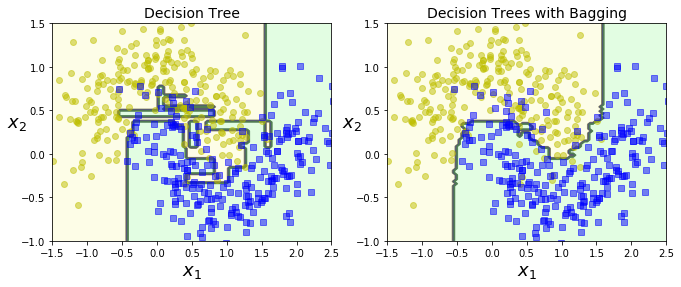

In [145]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

### Out-of-Bag Evaluation
By default a **BaggingClassifier samples m training instances with replacement (bootstrap=True), where m is the size of the training set.** <font color=red>This means that only about 63% of the training instances are sampled on average for each predictor. The remaining 37% of the training instances that are not sampled are called out-of-bag (oob) instances. Note that they are not the same 37% for all predictors.</font>

**Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set or cross-validation.** 

<font color=red>You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor. </font> In Scikit-Learn, you can set oob_score=True when creating a BaggingClassifier to request an automatic oob evaluation after training. The following code demonstrates this. 

The resulting evaluation score is available through the oob_score_ variable: ***THIS IS THE AVERAGE OOB SCORE. NEAT!!!***


In [146]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), 
                            n_estimators=500,
                            bootstrap=True, n_jobs=-1, 
                            oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.90400000000000003

In [147]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.89600000000000002

<font size=5 color=red >Soooo we got similar accuracy scores on the Out of Bag (OOB) and the actualy test sets. Makes sense!!!!</font>

### Random Patches and Random Subspaces
The BaggingClassifier class supports **sampling the features as well**. This is controlled by twohyperparameters: 
- max_features and 
- bootstrap_features. 

**They work the same way as max_samples and bootstrap, but for feature sampling instead of instance sampling. Thus, each
predictor will be trained on a random subset of the input features.**

<font size=5><br>**This is particularly useful when you are dealing with high-dimensional inputs (such as images).** <br></font>

**RANDOM PATCHES:** Sampling both training instances and features is called the Random Patches method.7 

**RANDOM SUB SPACES: **Keeping all
training instances (i.e., bootstrap=False and max_samples=1.0) but sampling features (i.e.,
bootstrap_features=True and/or max_features smaller than 1.0) is called the RandomSubspaces method.

***Sampling features results in even more predictor diversity, trading a bit more bias for a lower
variance.***

### Random Forests

As we have discussed, a Random Forest9 is an ensemble of Decision Trees, generally ***trained via the bagging method (or sometimes pasting)******,
- typically with max_samples set to the size of the training set (so each tree can sample the number of samples in the training set (though with BAGGING (with replacement) thatll result in about 67% of samples being selected).

<font color=red size=5>Instead of building a BaggingClassifier and passing it a DecisionTreeClassifier, you can instead use the RandomForestClassifier class, which is more convenient and optimized for Decision Trees10 (similarly, there is a RandomForestRegressor class for regression tasks). </font>

The following code trains a Random Forest classifier with 500 trees (each limited to maximum 16 nodes), **using all available CPU cores:**

In [148]:
from sklearn.ensemble import RandomForestClassifier

#n_estimators = number of trees
#max_leaf_nodes = max number of final leaf nodes
#n_jobs = -1 tells comp to use parrallelize with all CPUs

rnd_clf = RandomForestClassifier(n_estimators=500, 
                                 max_leaf_nodes=16, 
                                 n_jobs=-1)

rnd_clf.fit(X_train,y_train)

y_pred_rf = rnd_clf.predict(X_test)

#### With a few exceptions a RandomForestClassifier has all the hyperparametersof a DecisionTreeClassifer (to control how the trees are grown) plus ALL the hyperparameters of a Bagging Classifier to conrol the ensemble itself

The random forest srearches for the best feature among a SUBSET of features. The result is tree diversity, which <font color=red size =4> trades a higher bias for a lower variance, generally yeilding a overall better and more generalizable model.</font> 

EXTRA TREES: At each node in a random forest tree, only a random subset of the features is considered for splitting. 

# Feature Importance

Lastly, if you look at a single Decision Tree,** important decisions are likely to appear CLOSER to the root of the tree (the top), while unimportant features will often appear closer to the leaves (OR NOT AT ALL).**

**It is therefore possible to get an estimate of a feature’s importance by computing the average depth at which it appears across all trees in the forest.** Scikit-Learn computes this automatically for every feature after training. You can access the result using the **feature_importances_** variable. 

#### So the higher the feature_importances_ value, the more important the feature! below, the petal length seems to be the most important!!!

In [149]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.095448342225
sepal width (cm) 0.0256458678073
petal length (cm) 0.434838697519
petal width (cm) 0.444067092449


### Feature importance calculation: There are indeed several ways to get feature "importances". As often, there is no strict consensus about what this word means.

In scikit-learn, we implement the "gini importance" or "mean decrease impurity", which is defined as the total decrease in node impurity (weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble.

# Feature Importance with MNIST dataset (images)

In [150]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [151]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [152]:
# default number of estimators
len(rnd_clf.estimators_)

10

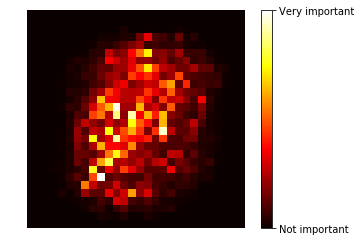

In [153]:
import matplotlib.pyplot as plt
import matplotlib

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")
    
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

#### Makes sense! The features in the middle of the image (where the actual print of the digit is) are the most important. 

<font color=red size=5> <br>In general, Random Forests are very handy to get a quick understanding of what features actually matter, especially if you need to perform Feature Selection </font>

### Adaptive Boosting: AdaBoost

Boosting refers to any Ensemble method that can combine several weak learners into a stronger learner. 

One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. For example, to build an AdaBoost classifier, a first base classifier (such as a Decision Tree) is
trained and used to make predictions on the training set. The relative weight of misclassified training instances is then increased. A second classifier is trained using the updated weights and again it makes predictions on the training set, weights are updated, and so on

The graphs below shows the decision boundaries of five consecutive predictors on the moons dataset (in this
example, each predictor is a highly regularized SVM classifier with an RBF kernel). 

**The first classifier gets many instances wrong, so their weights get boosted. The second classifier therefore does a better job on these instances, and so on. The plot on the right represents the same sequence of predictors except that the learning rate is halved** ***(i.e., the misclassified instance weights are boosted half as much at every iteration).***  

As you can see, this sequential learning technique has some similarities with Gradient Descent, <font size=5>except that instead of tweaking a single predictor’s parameters to minimize a cost function, AdaBoost adds predictors to the ensemble, gradually making it better.</font>

C:\Users\mciniello\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


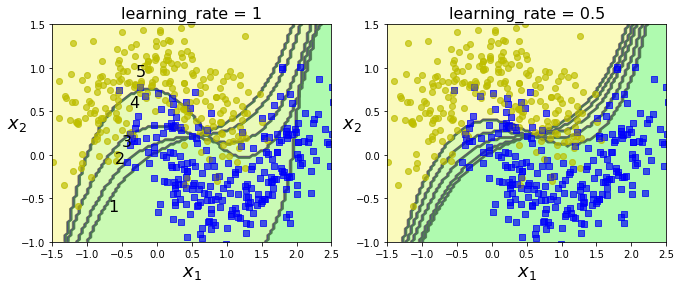

In [154]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    for i in range(5):
        plt.subplot(subplot)
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights) #set sample weights to 1 at first (normal SVC)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate) #update the sample_weights
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

plt.subplot(121)
plt.text(-0.7, -0.65, "1", fontsize=16)
plt.text(-0.6, -0.10, "2", fontsize=16)
plt.text(-0.5,  0.10, "3", fontsize=16)
plt.text(-0.4,  0.55, "4", fontsize=16)
plt.text(-0.3,  0.90, "5", fontsize=16)
plt.show()

In [155]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))


['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']


<font colir=red size=4> Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting,
**except that predictors have different weights depending on their overall accuracy on the weighted training set.**<br></font>

<font color=red size=5><br>**WARNING:** There is one important drawback to this sequential learning technique: it cannot be parallelized (or only partially), since each predictor can only be trained after the previous predictor has been trained and evaluated. As a result, it does not scale as well as bagging or pasting. GOOD TO NOTE!!!</font>

## The AdaBoost Algorithm

In AdaBoost, each instance weight is initially set to 1/m. A first predictor is trained and its **weighted error rate (r)** is computed on the training set. 

![](Pictures/adabalgo.png)

The predictor’s weight αj is then computed using the below equation, where η is the learning rate hyperparameter (defaults to 1). The more accurate the predictor is, the higher its weight will be. If it is just guessing randomly, then its weight will be close to zero

![](Pictures/adabalgo2.png)

![](Pictures/adabalgo3.png)

Finally, a new predictor is trained using the updated weights, and the whole process is repeated (the new predictor’s weight is computed, the instance weights are updated, then another predictor is trained, and so on). The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found. To make predictions, AdaBoost simply computes the predictions of all the predictors and weighs them using the predictor weights αj. The predicted class is the one that receives the majority of weighted votes.

![](Pictures/adabalgo4.png)



## SAMME: Stagewise Additive Modeling using Multiclass Exponential Loos function

SKlearn actually uses a multiclass version of AdaBoost called SAMME. Which there are just two classes, SAMME is equiv to AdaBoost. ALSO, if the preditors can estimate probabilities (ie if they have a predict_proba() method), then SKL uses a variant of SAMME called SAMME.R, which relies of probabilities rather than predictions AND GENERALLY PERFORMS BETTER. This goes back to the the thing about soft vs hard voting we discussed earlier!!! Neat!

**The following code trains an AdaBoost classifier based on 200 Decision Stumps using Scikit-Learn's AdaBoostClassifier class (though there is also an AdaBoostRegressor!!!!!). A Decision Stump is a Decision Tree with max_depth=1, in other words, a tree composed of decision node plus two leaf nodes. THIS IS THE FEAULT BASE ESTIMATOR FOR ADABOOSTCLASSIFIER!!!

### PRO TIP: If AdaBoost ensemble is overfitting the training set, you can try reducing the number of estimators or more strongly regularizing the base estimator.

In [156]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=None)

# Gradient Boosting

Another very popular Boosting algo is Gradient Boosting. Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

Let's go through a simple regression example using DTs, this is called Gradient Tree Boosing, or Gradient Booster Regression Trees (GBRTs). 

1. First we fit a DecisionTreeRegressor to the training set (for example, a noisy quadratic training set like below!)
2. Then train a second DTR on the residual errors made by the first predictor
3. Then we train a third regressor on the residual errors made by the second predictor

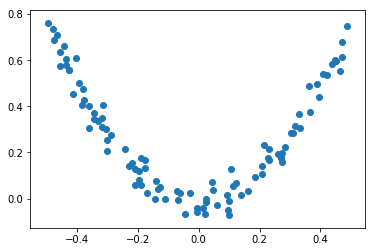

In [157]:
#create quadratic data
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)
plt.scatter(X,y)
plt.show()

In [158]:
#train tree 1
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

#train tree 2 on residuals of tree 1
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

#train a third regressor on the residual errors made by the second predictor
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Now we have an ensemble containing three tree. **It can make predictions on a new instance simply by adding up the predictions of all the trees:**

In [159]:
X_new = np.array([[0.1]]) #new X values
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1,tree_reg2,tree_reg3))
y_pred

array([ 0.04021166])

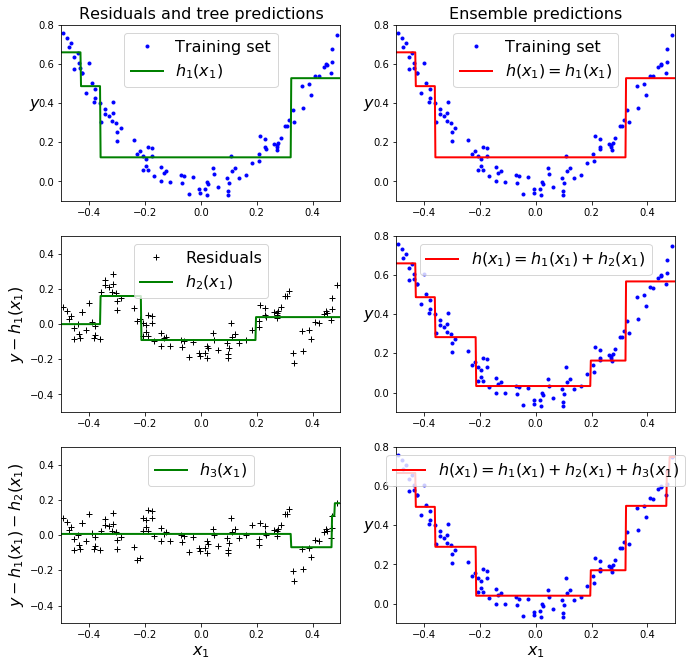

In [160]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

The plots above represent the predictions of the three trees on the left (first ensemble and then residuals), AND the ensembles predictions on the right! 

**On the right you can see that the ensemble's predictions are equal to the sum of the predictions of the first two trees. Similarily, in the third row another tree is training on the residual errors you see in the seocnd tree!**

A simpler way to train a **Gradient Boosting Residual Tree (GBRT)** is to use GradientBoostingRegressor in SKL. Much like Randomforest, it has hyperparams to control growth of the trees, as well as the number of trees (n_estimators). The following code recreates the previous code but is much easier!!!

In [161]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, 
                                 n_estimators=3, 
                                 learning_rate=1)

gbrt.fit(X,y)
gbrt.predict(X_new)

array([ 0.04021166])

#### NICE! Same result as before. So scikitlearn's GBR uses DTs as a defaul. Neat!!!

**Shrinkage**: Now, you may have notice I used a **learning rate hyperparameter** above. This is used to scale the contribution of each tree. If you set it to a low value such as 0.1, you will need MORE trees in teh ensemble to fit the training set... BUT the predictions will usually generalize better. **This is a regularization technique called 'Shrinkage'**. The graph below shoes two GBRT ensembles trianined with a low learning rate: 
- the one on the elft does NOT have enough trees to fit the training set
- while the one on the right has TOO MANY trees and overfits the training set

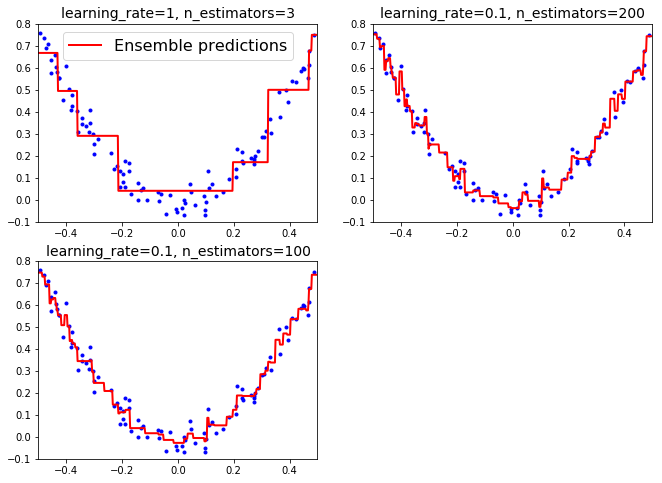

In [162]:
from sklearn.ensemble import GradientBoostingRegressor

#3 estimators
gbrt = GradientBoostingRegressor(max_depth=2,
                                n_estimators=3,
                                learning_rate=1,
                                random_state=42)
gbrt.fit(X,y)

#200 estimators
gbrt_slow = GradientBoostingRegressor(max_depth=2,
                                      n_estimators=200,
                                      learning_rate=0.1,
                                      random_state=42)
gbrt_slow.fit(X,y)

#100 estimators
gbrt_med = GradientBoostingRegressor(max_depth=2,
                                      n_estimators=100,
                                      learning_rate=0.1,
                                      random_state=42)
gbrt_med.fit(X,y)


plt.figure(figsize=(11,8))

plt.subplot(221)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(222)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.subplot(223)
plot_predictions([gbrt_med], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_med.learning_rate, gbrt_med.n_estimators), fontsize=14)

plt.show()

### Early Stopping with staged_predict()

In order to find the optimal number of trees you can implement early stopping!!! A simple way to do so is to use staged_predict() method: 
- it returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, three trees, etc.),. 

<font color=red> The following code trains a GBRT ensemble with 120 trees, then measures the validations error at each stage of training to find the optimal number of trees, and finally trains another GBRT ensemble using the optimal number of trees:</font>

In [163]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, 
                                 n_estimators=120)
gbrt.fit(X_train, y_train)

#get errors at each stage (should return 120 error vals!)
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]

min_error = np.min(errors)
print(np.min(errors))
len(errors)


0.00274265959944


120

In [164]:
#extract number of models with best val score (lowest MSE)
best_n_estimators = np.argmin(errors)
best_n_estimators

84

In [165]:
#run new model using 58 predictors (which should provide lowest val score!)
gbrt_best = GradientBoostingRegressor(max_depth=2, 
                                      n_estimators = best_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=84, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

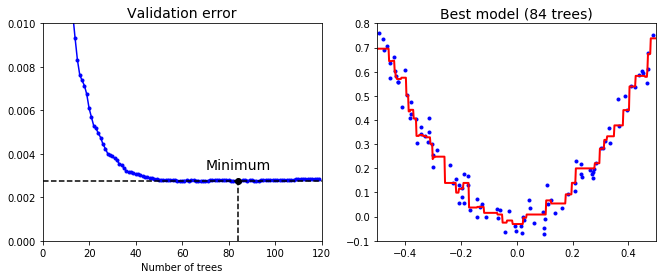

In [166]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.text(best_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % best_n_estimators, fontsize=14)

plt.show()

# More early stopping!

It is also possible to implement early stopping by actually stoppin training early (instead of training a large number of training and selecting the lowest error value).

You do so by setting **warm_start=True**, which makes SKL keep existing trees when the fit() mehtod is called, allowing incremental training. The following code stops training when the validaiton error does not improve for fiver iterations in a row:

In [167]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1,120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break #early stopping

### Stochastic Gradient Boosting

The GradientBoostingRegressor class also supports a **subsample hyperparameter, which specifies the fraction of training instances to be used for training each tree.** For example, if subsample=0.25, then each tree is trained on 25% of the training instances, selected randomly. As you can probably guess by now, **this trades a higher bias for a lower variance. It also speeds up training considerably.** This technique is called Stochastic Gradient Boosting.

It is possible to use Gradient Boosting with other cost functions. This is controlled by the loss hyperparameter (see Scikit-Learn’s documentation for more details).

# Model Stacking!!!

Stacking, or **Stacked Generalization** it based on a simple idea: instead of using trivial functions (such as hard voting) to aggregate predictions of all predictors in an ensemble, why dont we train model to perform this aggregation!!!!!!

The pic below shows such an ensemble performing a regression task on a new instance. Each of the bottom three predictors predicts a different value (3.1, 2.7, and 2.9), and then the final predictor <font color=red> (called a blender, or a meta learner)</font> takes these predictions as inputs and makes the final prediction (3.0).
![](Pictures/Stacking.jpg)

**To train the blender, a commong approach is to us a hold-out set:**
1. first the training set is split into two subsets. The first subset is used to train the predictors in the first layer.
2. Next the first layer predictors are used to make predictions on the second (held-out) set. This ensures that the predictions are "clean", since they predictors never saw these instances during training. 
3. Now for each instance in the hold-out set, there are three predicted values (on for each predictor), **we can create a new training set using these predicted values as input features** (which makes this training set three-dimensional). Using the target values, the blender is trained on this new training set, <font color=red> SO IT LEARN TO PREDICT THE TARGET VALUE GIVEN THE FIRST LAYERS PREDICTIONS!!! COOOL! Kinda like a neural net no? </FONT>

It is actually possible to train several different blenders this way (e.g., one using Linear Regression, another using Random Forest Regression, and so on): we get a whole layer of blenders. <font color=red>The trick isto split the training set into three subsets: the first one is used to train the first layer, the second one is
used to create the training set used to train the second layer (using predictions made by the predictors of the first layer), and the third one is used to create the training set to train the third layer (using predictions made by the predictors of the second layer). </font>Once this is done, we can make a prediction for a new instance by going through each layer sequentially!

# Questions:

**1. If you have trained five different models on the exact same training data, and they all achieve 95% precision, is there any chance that you can combine these models to get better results? If so, how? If not, why?**

- Hundo p. If you have trained five different models and they all achieve 95% precision, you can try combining them into a voting ensemble, which will often give you even better results. It works better if the models are very different (e.g., an SVM classifier, a Decision Treeclassifier, a Logistic Regression classifier, and so on). It is even better if they are trained on different training instances (that’s the whole point of bagging and pasting ensembles), but if not it will still work as long as the models are very different.

**2. What is the difference between hard and soft voting classifiers?**
- A hard voting classifier just counts the votes of each classifier in the ensemble and picks the class that gets the most votes. A soft voting classifier computes the average estimated class probability for each class and picks the class with the highest probability. This gives highconfidence votes more weight and often performs better, but it works only if every classifier is able to estimate class probabilities (e.g., for the SVM classifiers in Scikit-Learn you must set probability=True).

**3. Is it possible to speed up training of a bagging ensemble by distributing it across multiple servers? What about pasting ensembles, boosting ensembles, random forests, or stacking ensembles?**

It is quite possible to speed up training of a bagging ensemble by distributing it across multiple servers, since each predictor in the ensemble is independent of the others. The same goes for pasting ensembles and Random Forests, for the same reason. <font color=blue>However, each predictor in a boosting ensemble is built based on the previous predictor, so training is necessarily sequential, and you will not gain anything by distributing training across multiple servers</font>. Regarding stacking ensembles, all the predictors in a given layer are independent of each other, so they can be trained in parallel on multiple servers. However, the predictors in one layer can only be trained after the predictors in the previous layer have all been trained.

**4. What is the benefit of out-of-bag evaluation?**

With out-of-bag evaluation, each predictor in a bagging ensemble is evaluated using instances that it was not trained on (they were not selected because when you do bagging - WITH replacement selection - only approx 66% of training instances get selected. This makes it possible to have a fairly unbiased evaluation of the ensemble without the need for an additional validation set. Thus, you have more instances available for training, and your ensemble can perform slightly better.


**5. What makes Extra-Trees more random than regular Random Forests? How can this extra randomness help? Are Extra-Trees slower or faster than regular Random Forests?**

When you are growing a tree in a Random Forest, only a random subset of the features is considered for splitting at each node. This is true as well for Extra-Trees, but they go one step further: rather than searching for the best possible thresholds, like regular Decision Trees do, they use random thresholds for each feature. This extra randomness acts like a form of regularization: if a Random Forest overfits the training data, Extra-Trees might perform better. Moreover, since Extra-Trees don’t search for the best possible thresholds, they are much faster to train than Random Forests. However, they are neither faster nor slower than Random Forests when making predictions.

**6. If your AdaBoost ensemble underfits the training data, what hyperparameters should you tweak and how?**

If your AdaBoost ensemble underfits the training data, you can try increasing the number of estimators or reducing the regularization hyperparameters of the base estimator. You may also try slightly increasing the learning rate.

**7. If your Gradient Boosting ensemble overfits the training set, should you increase or decrease the learning rate?**

If your Gradient Boosting ensemble overfits the training set, you should try decreasing the learning rate. <font color=blue>You could also use early stopping to find the right number of predictors (you probably have too many!)</font>